In [1]:
from qiskit import *
import numpy as np
import pylab as pl
import networkx as nx
from qiskit.visualization import *
from qiskit.providers.aer.noise import NoiseModel
from qaoa import *
from pylab import cm
from matplotlib.widgets import Slider, Button, RadioButtons

from matplotlib import rc,patches
from scipy import optimize as opt

SAMPLING_E_ATOL = 5e-2
SAMPLING_E_RTOL = 1e-2
SAMPLING_DELTA_V_RTOL = 1e-1
MIN_SAMPLES = 256
MAX_SAMPLES = 32768*2*2
SAMPLING_CONF_IDX = 1

LANDSCAPE_NYQ_FREQ = 32
WEIGHT_DECIMALS = 1

CIRCUIT_VERSION = 1
CIRCUIT_DEPTH = 1

font = {'size' : 16}
rc('font', **font);
rc('text', usetex=True)

backend_sim = Aer.get_backend('qasm_simulator')

In [2]:
def sample_landscape(G,gammas,betas,landscape_n_gamma,landscape_n_beta):
    E_landscape = np.zeros((landscape_n_beta,landscape_n_gamma))
    v_landscape = np.zeros((landscape_n_beta,landscape_n_gamma))
    circuits=[]
    for i in range(landscape_n_beta):
        for j in range(landscape_n_gamma):
            beta = betas[i]
            gamma = gammas[j]
            circuit = createCircuit_MaxCut(np.array((gamma,beta)),G,CIRCUIT_DEPTH,CIRCUIT_VERSION)
            [E_list,v_list,_] = sampleUntilPrecision_MaxCut(circuit,G,backend_sim,None,MIN_SAMPLES,
                                                                 MAX_SAMPLES,SAMPLING_E_ATOL,SAMPLING_E_RTOL,
                                                                 SAMPLING_DELTA_V_RTOL,SAMPLING_CONF_IDX)
            E_landscape[i,j] = E_list[-1]
            v_landscape[i,j] = v_list[-1]
            print('%.2f%%' % ((i*landscape_n_gamma+j)*100/(landscape_n_gamma*landscape_n_beta)),end='\r')
    
    return E_landscape,v_landscape

100%
Max cost: 3


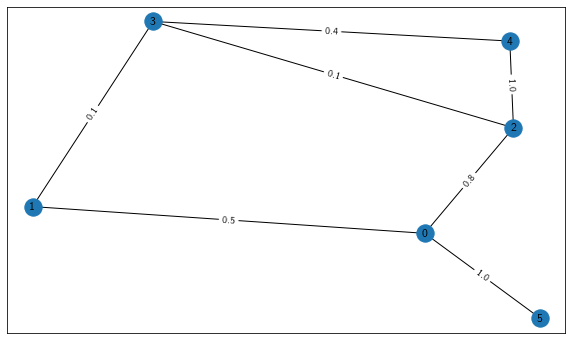

In [3]:
V = np.arange(0,6,1)
E =[(0,1),(0,2),(2,3),(3,1),(3,4),(4,2),(0,5)]
G = nx.Graph()
G.add_nodes_from(V)
G.add_edges_from(E)

#np.random.seed(3)
addWeights_MaxCut(G,decimals=WEIGHT_DECIMALS)

pos = nx.spring_layout(G)
labels = nx.get_edge_attributes(G,'weight')

pl.figure(figsize=(10,6))
nx.draw_networkx(G,pos)
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

V1 = np.arange(0,)
costs=costsHist_MaxCut(G)
max_cost = max(costs)
print('Max cost: %d' % max_cost)

In [4]:
(gamma_min,gamma_max),(beta_min,beta_max) = parameterBounds_MaxCut(G,decimals=WEIGHT_DECIMALS)

max_weight = max([w for _,_,w in G.edges.data('weight',default=1)])
landscape_n_gamma = int(LANDSCAPE_NYQ_FREQ*np.ceil(gamma_max*(max_weight/2)/(2*np.pi)))
landscape_n_beta = int(LANDSCAPE_NYQ_FREQ*np.ceil(beta_max/(2*np.pi)))

print('landscape_n_gamma: %d' % landscape_n_gamma)
print('landscape_n_beta: %d' % landscape_n_beta)

gammas_landscape = np.linspace(gamma_min,gamma_max,landscape_n_gamma)
betas_landscape = np.linspace(beta_min,beta_max,landscape_n_beta)

E_landscape,v_landscape = sample_landscape(G,gammas_landscape,betas_landscape,landscape_n_gamma,landscape_n_beta)

landscape_n_gamma: 96
landscape_n_beta: 32


Text(0, 0.5, 's')

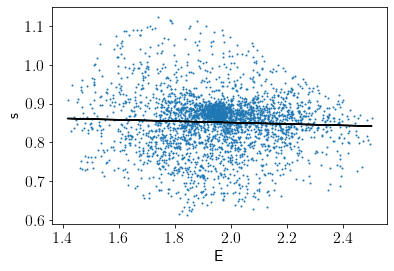

In [9]:
Es = E_landscape.flatten()
ss = np.sqrt(v_landscape).flatten()

m,b = np.polyfit(Es,ss,1)

pl.figure()
pl.scatter(Es,ss,s=1)
pl.plot(Es,m*Es+b,'k')
pl.xlabel('E')
pl.ylabel('s')

Text(0, 0.5, '$\\beta$')

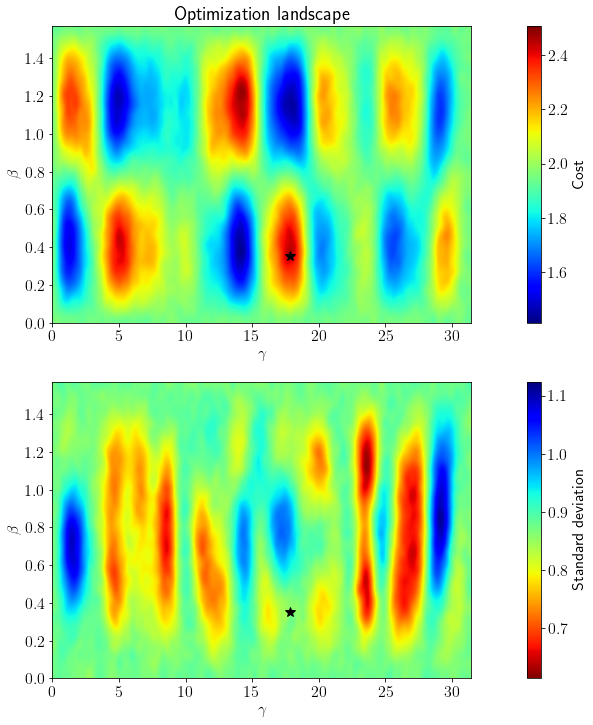

In [6]:
idxs_peak = np.where(E_landscape == np.amax(E_landscape))
idxs_peak = list(zip(idxs_peak[0],idxs_peak[1]))

pl.figure(figsize=(10, 12))

pl.subplot(2,1,1)
pl.imshow(np.array(E_landscape).reshape(landscape_n_beta,landscape_n_gamma),
          origin='lower',interpolation='bicubic',cmap=cm.jet,aspect='auto',
          extent=[gammas_landscape[0],gammas_landscape[-1],betas_landscape[0],betas_landscape[-1]])
cbar = pl.colorbar(orientation="vertical", pad=0.1)
cbar.set_label('Cost')
for idx_peak in idxs_peak:
    beta_peak = betas_landscape[idx_peak[0]]
    gamma_peak = gammas_landscape[idx_peak[1]]
    pl.plot(gamma_peak,beta_peak,'k*',ms=10)
pl.xlabel(r'$\gamma$')
pl.ylabel(r'$\beta$')
pl.title('Optimization landscape')

pl.subplot(2,1,2)
pl.imshow(np.array(np.sqrt(v_landscape)).reshape(landscape_n_beta,landscape_n_gamma),
          origin='lower',interpolation='bicubic',cmap=cm.jet.reversed(),aspect='auto',
          extent=[gammas_landscape[0],gammas_landscape[-1],betas_landscape[0],betas_landscape[-1]])
cbar = pl.colorbar(orientation="vertical", pad=0.1)
cbar.set_label('Standard deviation')
for idx_peak in idxs_peak:
    beta_peak = betas_landscape[idx_peak[0]]
    gamma_peak = gammas_landscape[idx_peak[1]]
    pl.plot(gamma_peak,beta_peak,'k*',ms=10)
pl.xlabel(r'$\gamma$')
pl.ylabel(r'$\beta$')

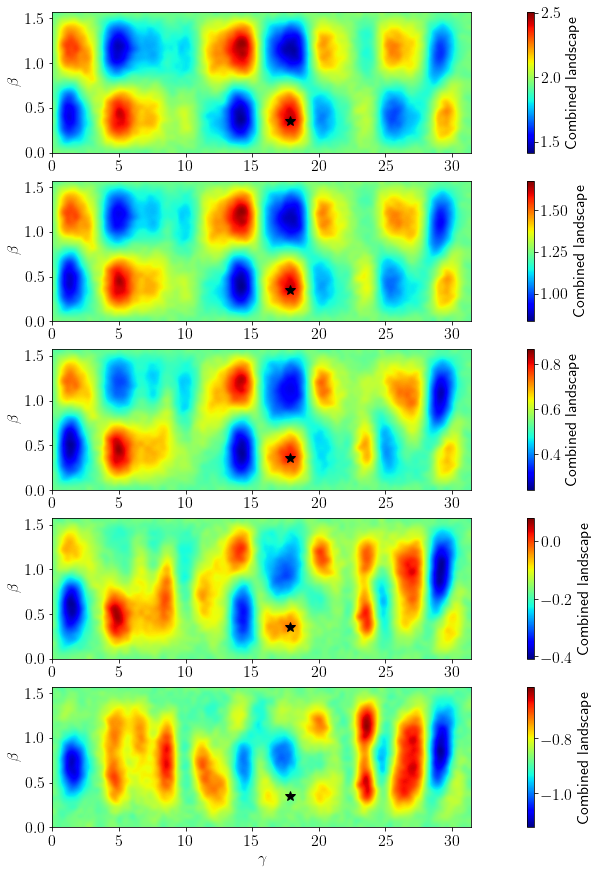

In [7]:
n_alphas = 5
alphas = np.linspace(0.0,1.0,n_alphas)

combined_landscapes = []
for alpha in alphas:
    combined_landscape = (1-alpha)*np.array(E_landscape) - np.array(alpha*np.sqrt(v_landscape))
    combined_landscapes.append(combined_landscape)
    
pl.figure(figsize=(10,n_alphas*3))
for i in range(n_alphas):
    pl.subplot(n_alphas,1,i+1)
    alpha = alphas[i]
    combined_landscape = combined_landscapes[i]
    pl.imshow(combined_landscape.reshape(landscape_n_beta,landscape_n_gamma),
          origin='lower',interpolation='bicubic',cmap=cm.jet,aspect='auto',
          extent=[gammas_landscape[0],gammas_landscape[-1],betas_landscape[0],betas_landscape[-1]])
    cbar = pl.colorbar(orientation="vertical", pad=0.1)
    cbar.set_label('Combined landscape')
    
    for idx_peak in idxs_peak:
        beta_peak = betas_landscape[idx_peak[0]]
        gamma_peak = gammas_landscape[idx_peak[1]]
    pl.plot(gamma_peak,beta_peak,'k*',ms=10)
    pl.xlabel(r'$\gamma$')
    pl.ylabel(r'$\beta$')